##  Import Libraries

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as stats

In [3]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
az.style.use('arviz-darkgrid')

In [33]:
%watermark -n -u -v -iv -w

pymc3 3.8
numpy 1.18.1
arviz 0.7.0
last updated: Sat May 02 2020 

CPython 3.6.10
IPython 7.13.0
watermark 2.0.2


## Code 2.1

In [3]:
ways = np.array([0, 3, 8, 9, 0])
ways / ways.sum()

array([0.  , 0.15, 0.4 , 0.45, 0.  ])

## Code 2.2

$$Pr(w \mid n, p) =  \frac{n!}{w!(n − w)!} p^w (1 − p)^{n−w}$$


The probability of observing six W’s in nine tosses—under a value of p=0.5

See the official Scipy [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html#scipy.stats.binom).

In [4]:
stats.binom.pmf(6, n=9, p=0.5)

0.16406250000000006

## Code 2.3 and 2.5

Computing the posterior using a grid approximation.

In the book the following code is not inside a function, but this way is easier to play with different parameters

In [40]:
def get_prior(parameter_grid, prior_type="uniform"):
    
    dbl_exp = np.exp(- 5 * abs(parameter_grid - 0.5))
    trunc = (parameter_grid >= 0.5).astype(int)
    rev_trunc = (parameter_grid <= 0.5).astype(int)
    
    prior_dict = {"uniform": np.repeat(1/len(parameter_grid), 
                                       len(parameter_grid)),
                  "truncated": trunc / trunc.sum(),
                  "reverse truncated": rev_trunc / rev_trunc.sum(),
                  "double exponential": dbl_exp / dbl_exp.sum()
                  }
    
    return prior_dict[prior_type]

In [37]:
def posterior_grid_approx(grid_points=5, success=6, tosses=9, prior_type="uniform"):
    """
    """
    # define grid.
    # Between 0 and 1, creates equally spaced samples for the parameter of interest.
    parameter_grid = np.linspace(0, 1, grid_points)

    prior = get_prior(parameter_grid, prior_type)
    
    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, parameter_grid)
    
    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    
    return parameter_grid, posterior

## Code 2.3

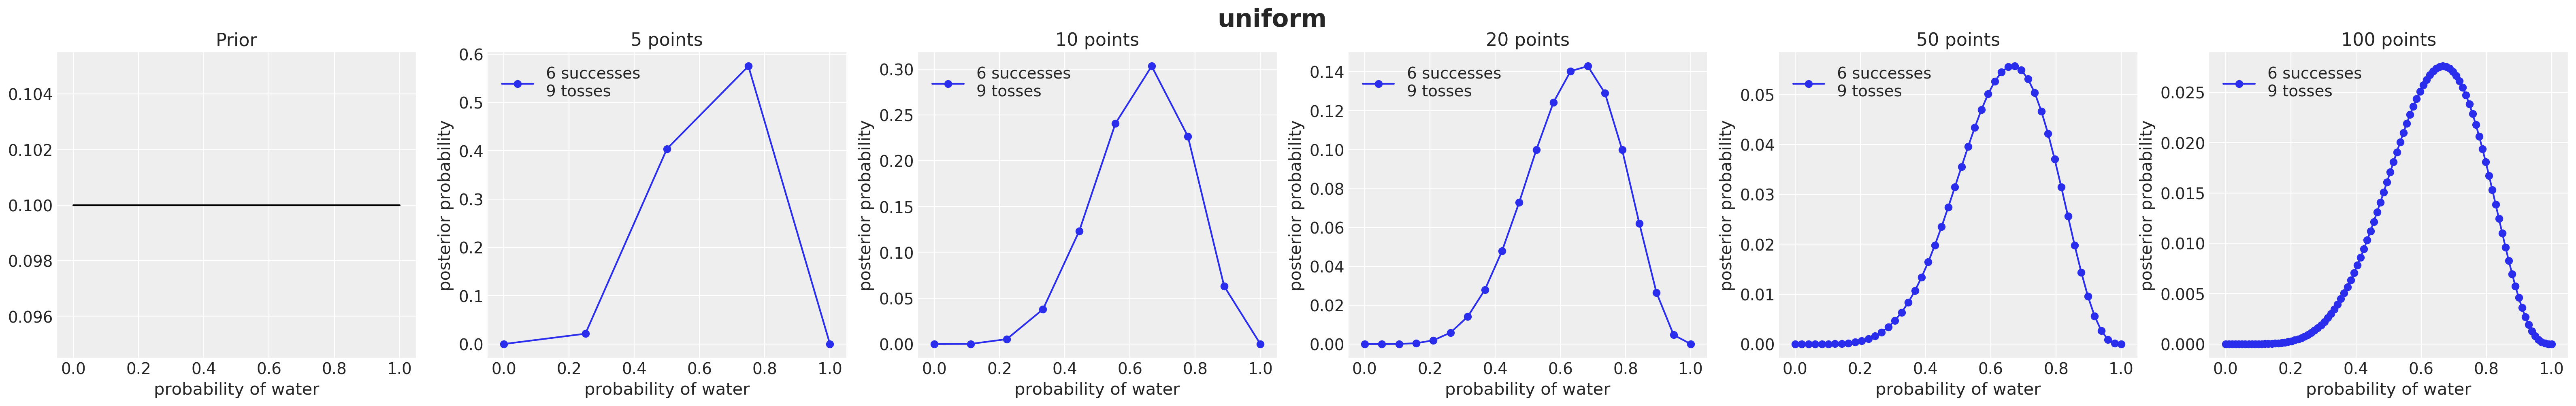

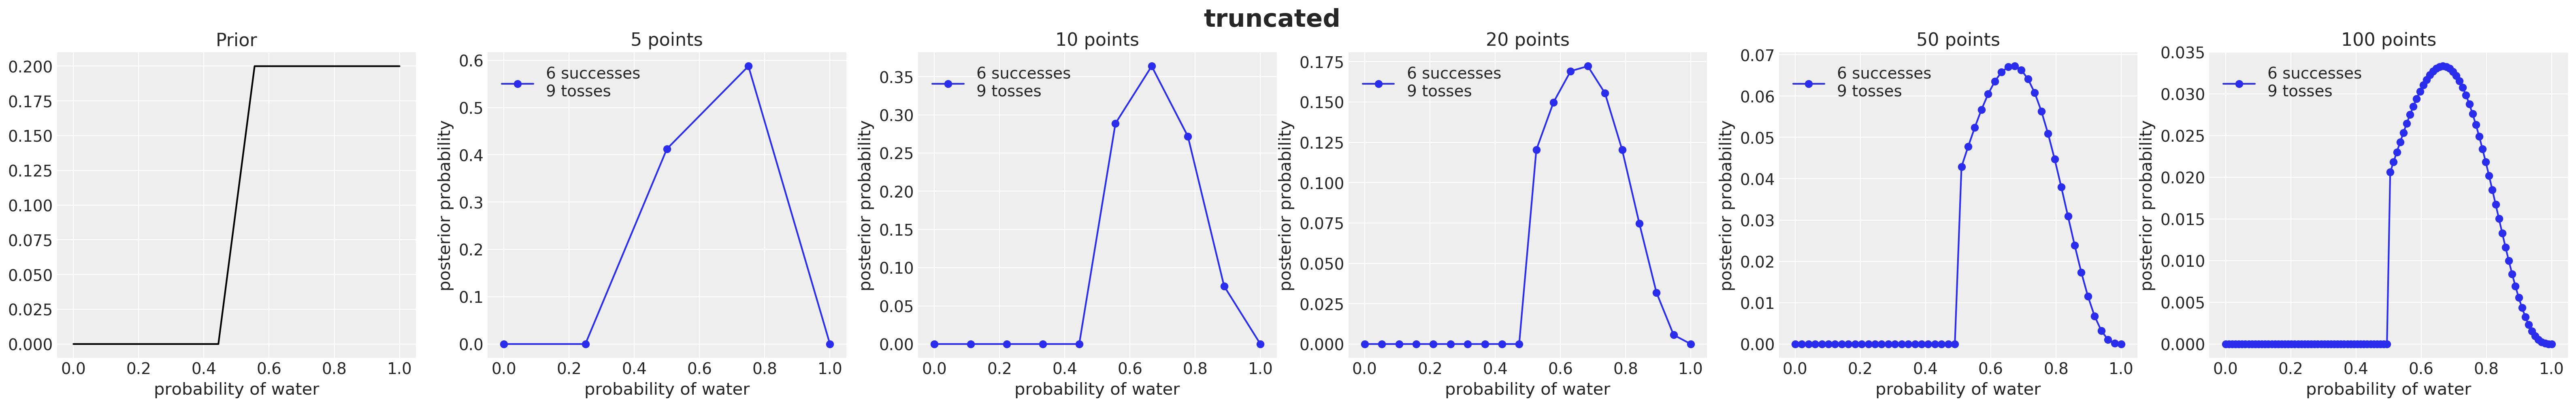

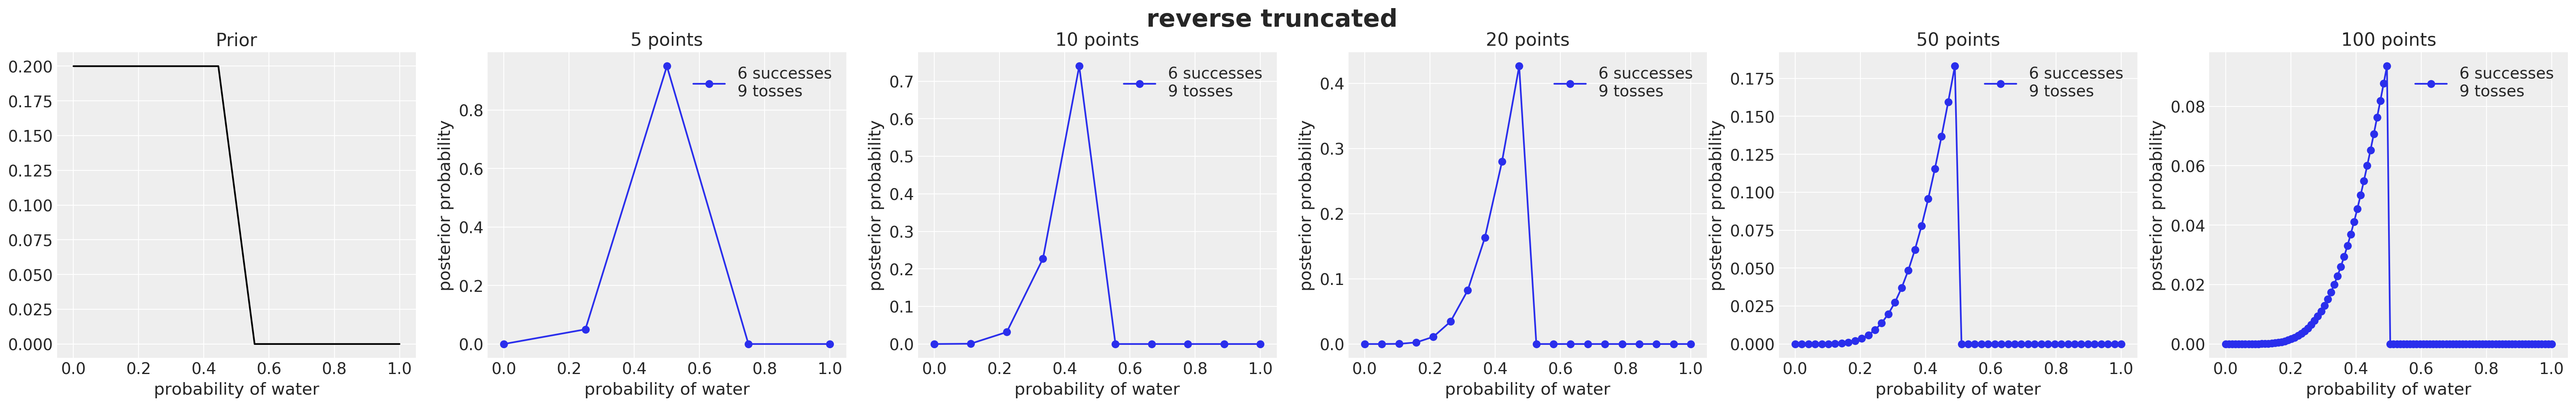

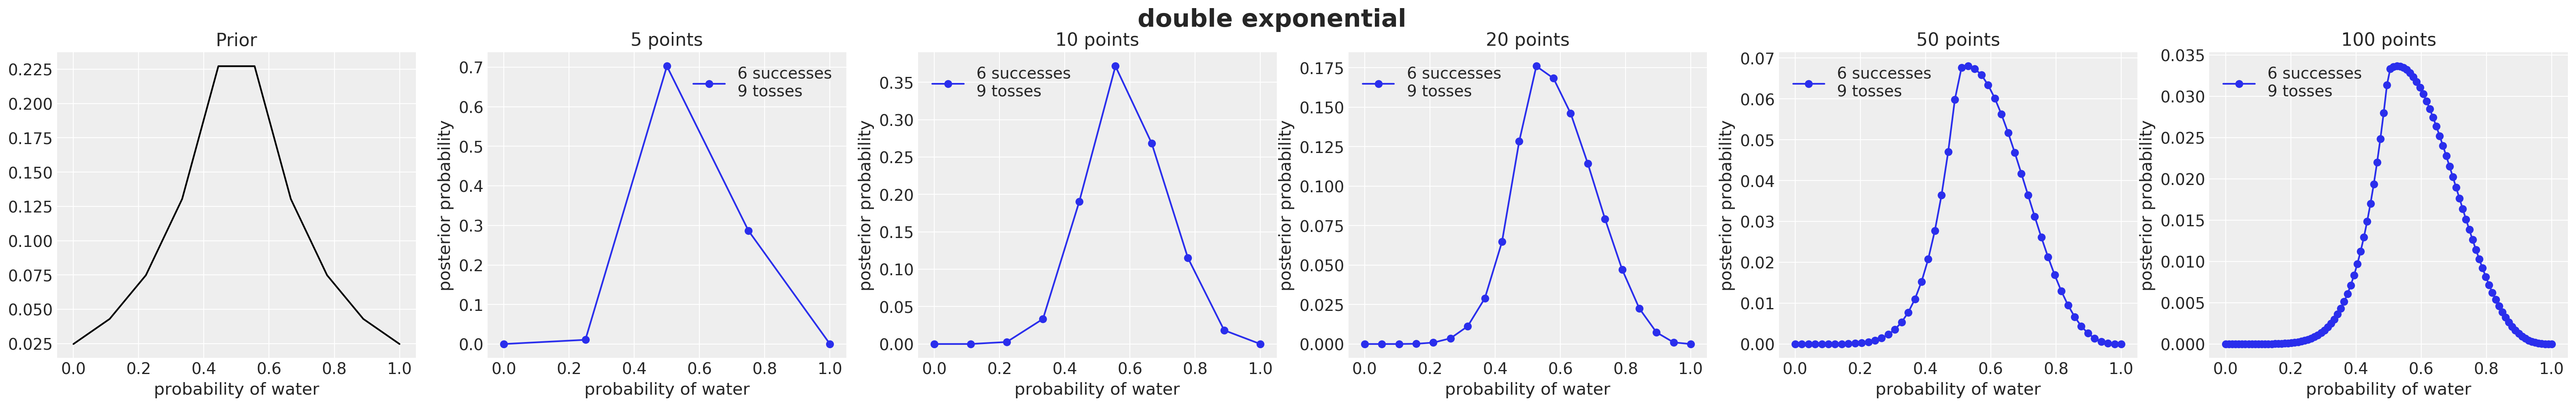

In [75]:
sucesess = 6
tosses = 9

probability_grid = (5, 10, 20, 50, 100)

    
for j, prior_type in enumerate(["uniform", "truncated", 
                                "reverse truncated", 
                                "double exponential"]):
    
    f, ax = plt.subplots(ncols=len(probability_grid)+1, 
                         figsize=(40, 5))
    
    prior_points = np.linspace(0, 1, 10)
    prior = get_prior(prior_points, prior_type)
    ax[0].plot(prior_points, prior, '-', color='k')
    ax[0].set_xlabel("probability of water")
    ax[0].set_title("Prior")
    
    for i, points in enumerate(probability_grid):
        CURRENT_AX = ax[i+1]
        
        p_grid, posterior = posterior_grid_approx(points, sucesess, tosses, prior_type)
        
        CURRENT_AX.plot(p_grid, posterior, "o-", label="{} successes\n{} tosses".format(w, n))
        CURRENT_AX.set_xlabel("probability of water")
        CURRENT_AX.set_ylabel("posterior probability")
        CURRENT_AX.set_title("{} points".format(points))
        CURRENT_AX.legend(loc=0)
        
    f.suptitle(f"{prior_type}", y=0.99, fontweight="bold", fontsize=22)
    

## Code 2.6

Computing the posterior using the quadratic aproximation

In [4]:
data = np.repeat((0, 1), (3, 6))

data

array([0, 0, 0, 1, 1, 1, 1, 1, 1])

In [5]:
with pm.Model() as normal_approximation:
    # Prior distribution of parameter p.
    p = pm.Uniform("p", 0, 1) 
    
    # The likelihood of the data, given parameter p.
    w = pm.Binomial("w", 
                    n=len(data),         # Number of trials
                    observed=data.sum()  # Number of successes
                    p=p,                 # Probability of success
                   )

In [6]:
normal_approximation

In [22]:
# Finds the local maximum a posteriori point given a model.
mean_q = pm.find_MAP(model=normal_approximation)

# Computes the StDev of the desired posterior
# by using the hessian of the MAP.
hessian_of_logp = pm.find_hessian(mean_q, vars=[p], 
                                  model=normal_approximation)[0][0]

std_q = 1 / (hessian_of_logp ** 0.5)

logp = -1.8075, ||grad|| = 1.5: 100%|██████████| 7/7 [00:00<00:00, 1092.23it/s]


In [23]:
mean_q # The item with key 'p' gives the MAP.

{'p_interval__': array(0.69314718), 'p': array(0.66666667)}

In [24]:
hessian_of_logp

40.50000006057694

In [25]:
std_q

0.15713484014616183

In [26]:
# Define a normal distribution with mean at the MAP
# and the StDev as computed above.
norm = stats.norm(loc=mean_q["p"], scale=std_q)

# To get the 95 CI.
# McElreath reports a 89% interval.
prob = 0.95

# Returns the Z-values for the desired interval.
# for p = 0.95, this will be ±1.96.
z = stats.norm.ppf([(1 - prob) / 2, (1 + prob) / 2])

# Computing the percentile interval!
pi = mean_q["p"] + std_q * z
pi

array([0.35868804, 0.97464529])

## Code 2.7

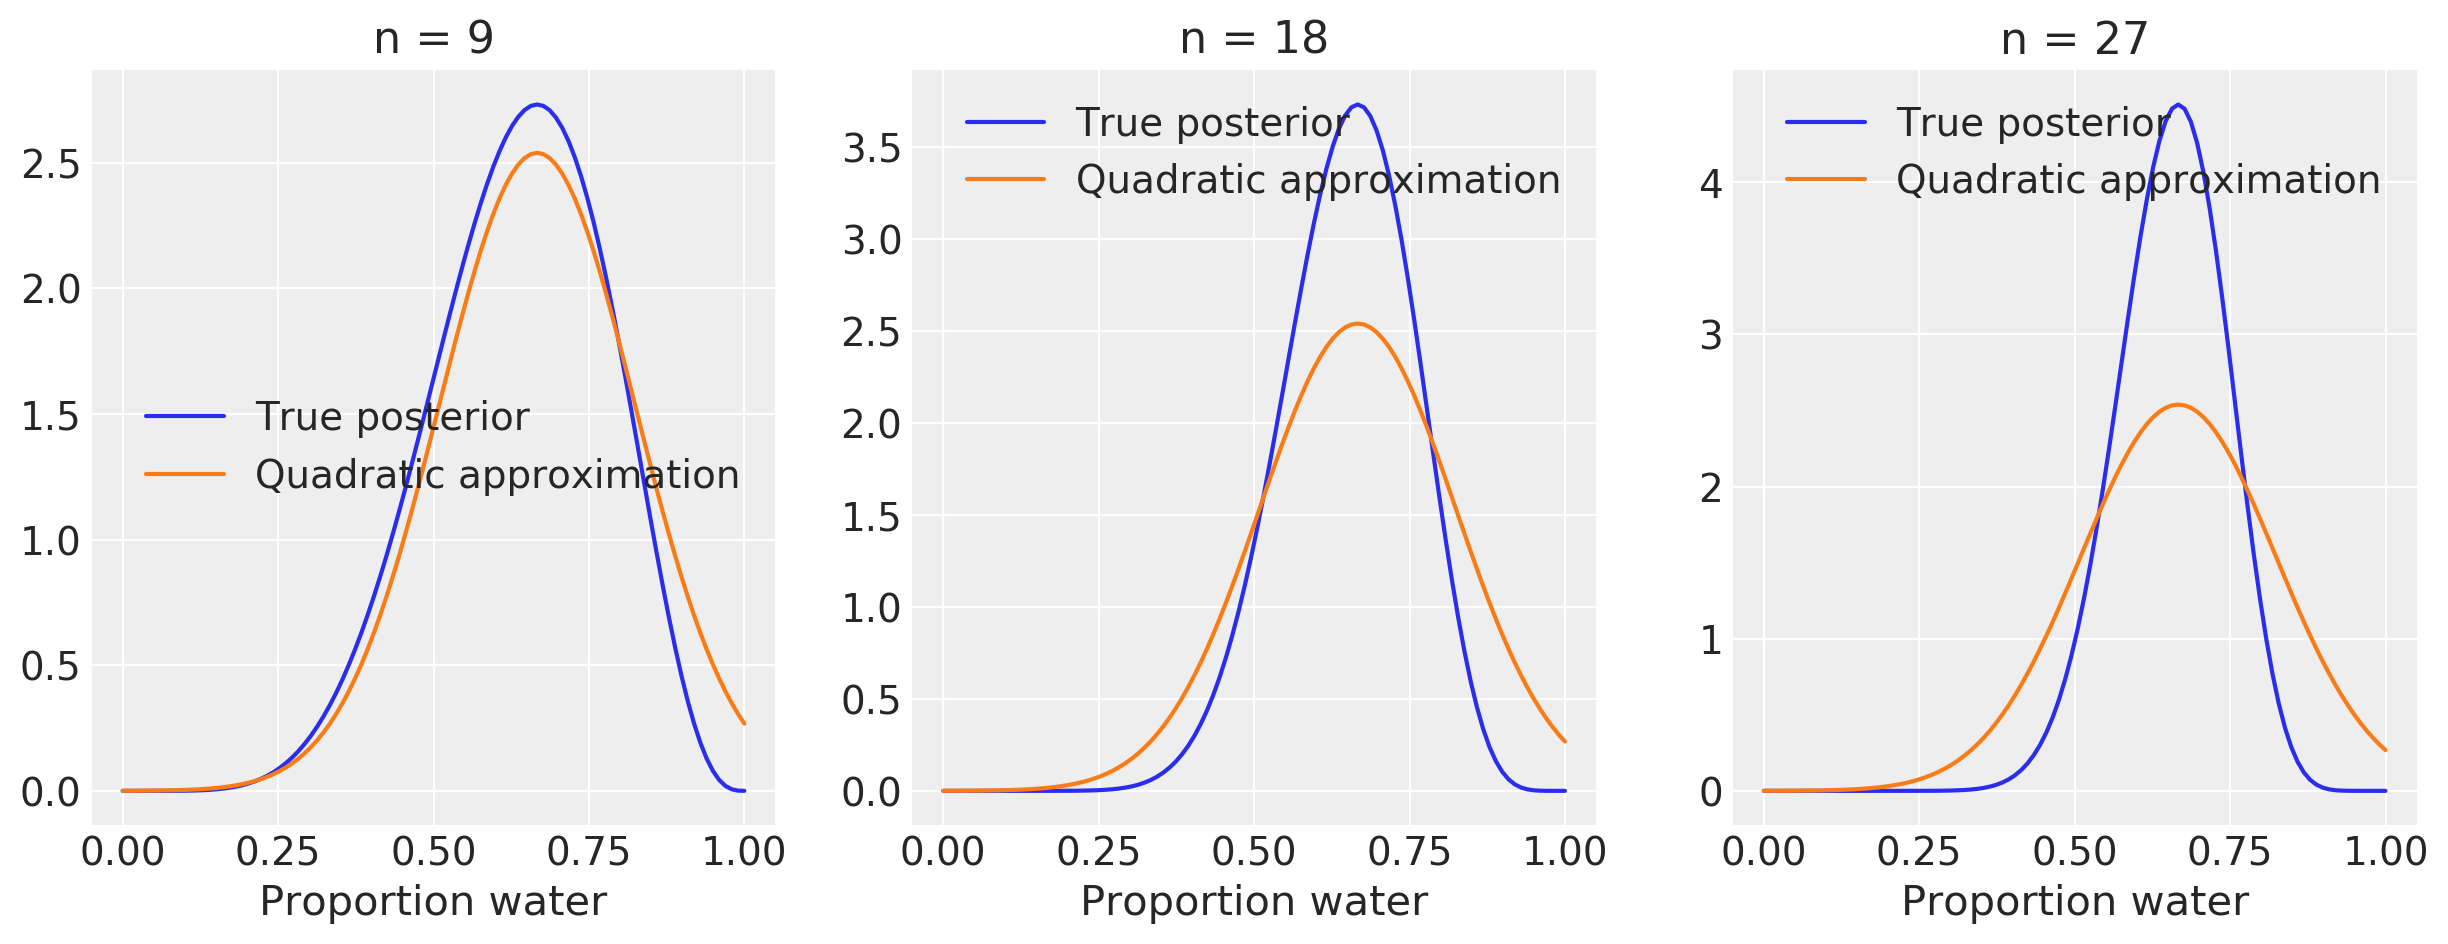

In [30]:
# analytical calculation
w, n = 6, 9
x = np.linspace(0, 1, 100)

f, axx = plt.subplots(ncols=3, figsize=(15,5))

for j, ax in enumerate(axx):
    w_ = w * (j+1)
    n_ = n * (j+1)
    
    ax.plot(x, stats.beta.pdf(x, w_ + 1, n_ - w_ + 1), label="True posterior")

    # quadratic approximation
    ax.plot(x, stats.norm.pdf(x, mean_q["p"], std_q), label="Quadratic approximation")
    ax.legend(loc=0)

    ax.set_title("n = {}".format(n_))
    ax.set_xlabel("Proportion water");

##  Code 2.8

In [10]:
n_samples = 1000
p = np.zeros(n_samples)
p[0] = 0.5
W = 6
L = 3
for i in range(1, n_samples):
    p_new = stats.norm(p[i - 1], 0.1).rvs(1)
    if p_new < 0:
        p_new = -p_new
    if p_new > 1:
        p_new = 2 - p_new
    q0 = stats.binom.pmf(W, n=W + L, p=p[i - 1])
    q1 = stats.binom.pmf(W, n=W + L, p=p_new)
    if stats.uniform.rvs(0, 1) < q1 / q0:
        p[i] = p_new
    else:
        p[i] = p[i - 1]

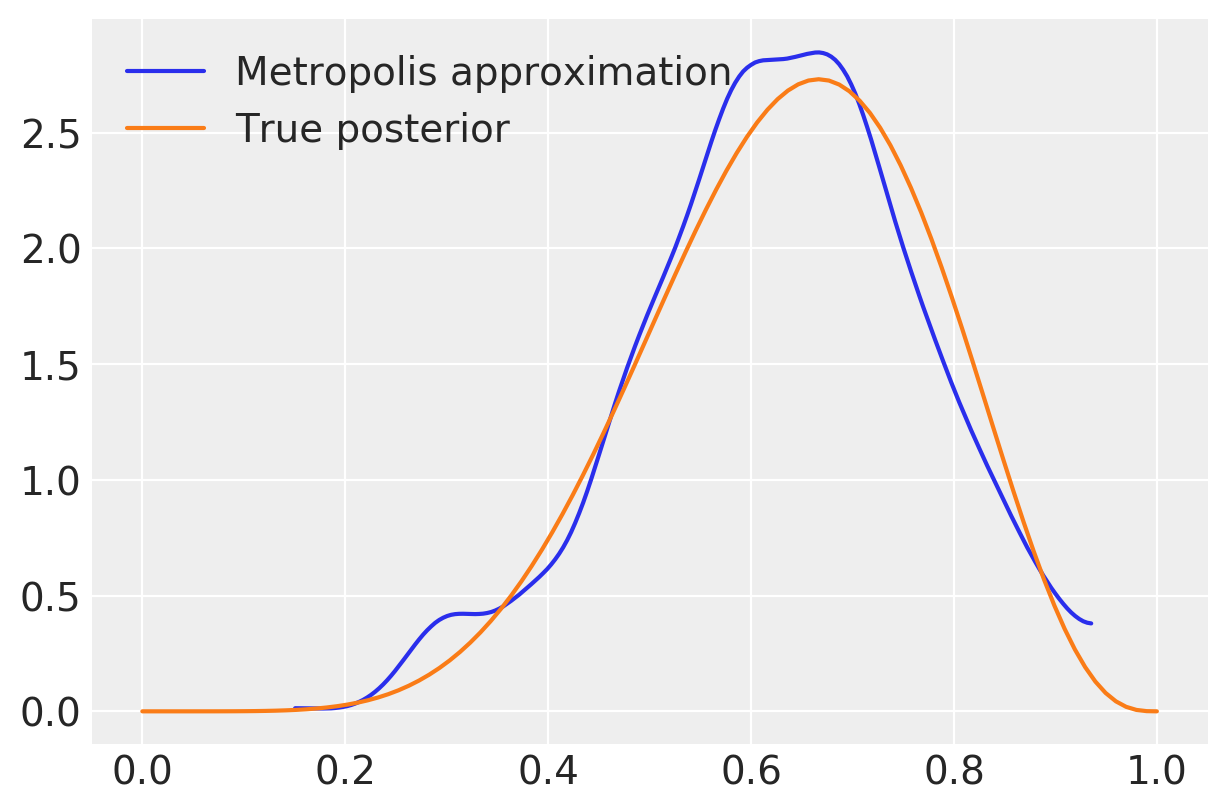

In [11]:
az.plot_kde(p, label="Metropolis approximation")
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, W + 1, L + 1), "C1", label="True posterior")
plt.legend();

## Excercises

### 2M1

Recall the globe tossing model from the chapter. Compute and plot the grid approximate posterior distribution for each of the following sets of observations. In each case, assume a uniform prior for p.

1. W,W,W
2. W,W,W,L
3. L,W,W,L,W,W,W

### 2M2

Now assume a prior for p that is equal to zero when p < 0.5 and is a positive constant when p ≥ 0.5. Again compute and plot the grid approximate posterior distribution for each of the sets of observations in the problem just above.



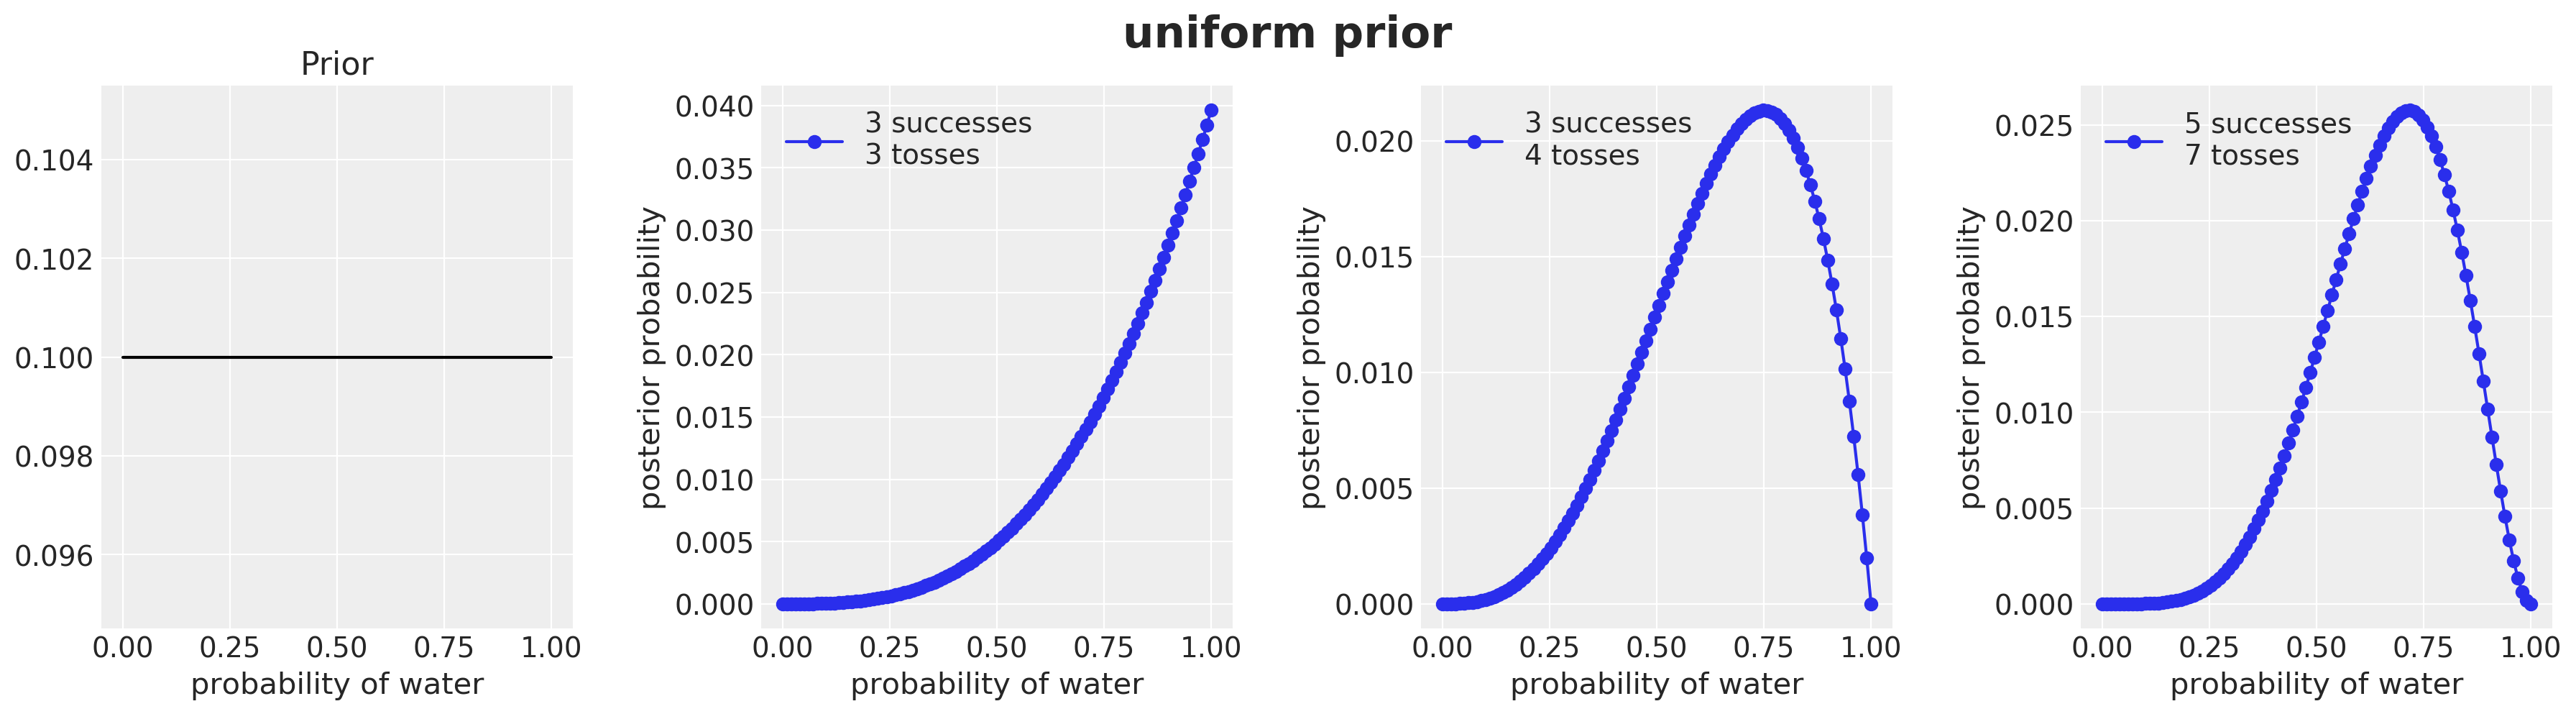

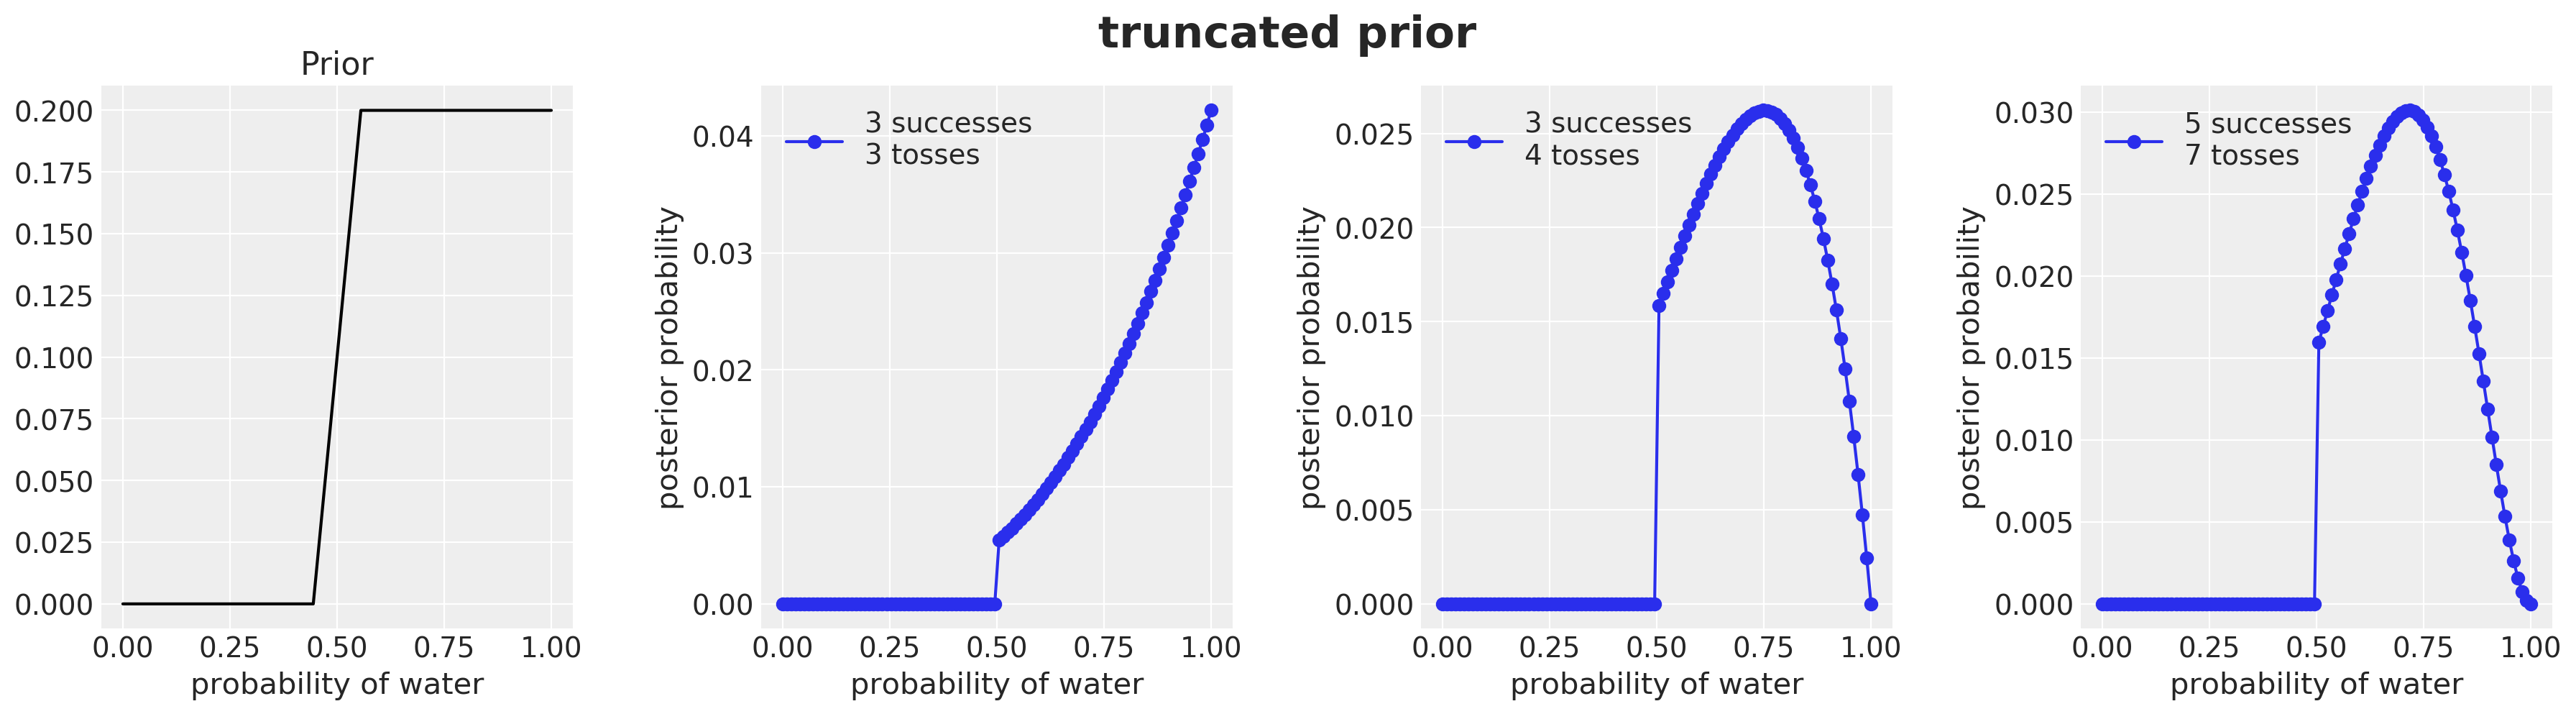

In [48]:
cases = {1: {'successes' : 3, 'tosses' : 3},
         2: {'successes' : 3, 'tosses' : 4},
         3: {'successes' : 5, 'tosses' : 7},
        }

grid_points = 100
    
prior_points = np.linspace(0, 1, 10)

for prior_type in ["uniform", "truncated"]:
    prior = get_prior(prior_points, prior_type)

    f, ax = plt.subplots(ncols=4, figsize=(22, 5), gridspec_kw={"wspace": 0.4})
    f.suptitle(f"{prior_type} prior", y=0.98, fontweight="bold", fontsize=22)

    ax[0].plot(prior_points, prior, '-', color='k')
    ax[0].set_xlabel("probability of water")
    ax[0].set_title("Prior")

    for j, key in enumerate(cases.keys()):
        successes = cases[key]['successes']
        tosses = cases[key]['tosses']
        CURRENT_AX = ax[key]

        p_grid, posterior = posterior_grid_approx(grid_points, successes, tosses, prior_type)

        CURRENT_AX.plot(p_grid, posterior, "o-", label=f"{successes} successes\n{tosses} tosses")
        CURRENT_AX.set_xlabel("probability of water")
        CURRENT_AX.set_ylabel("posterior probability")

        CURRENT_AX.legend(loc=0)